In [1]:
import os, PIL, torch, torch.nn as nn, torchvision, matplotlib.pyplot as plt
from tqdm.notebook import tqdm

train_folder = 'data/train/'

In [2]:
filenames=[]
for filename in os.listdir(train_folder):
    filenames.append(filename)
    
labels=[]
for filename in filenames:
    if filename[:3]=='dog':
        labels.append(1)
    else:
        labels.append(0)
        
classes={0:'cat', 1:'dog'}

In [3]:
def load_batch_of_images(batch_filenames):
    # load images as PIL images
    batch_images=[]
    for filename in batch_filenames:
        image=PIL.Image.open(train_folder+filename)
        batch_images.append(image)
    return batch_images

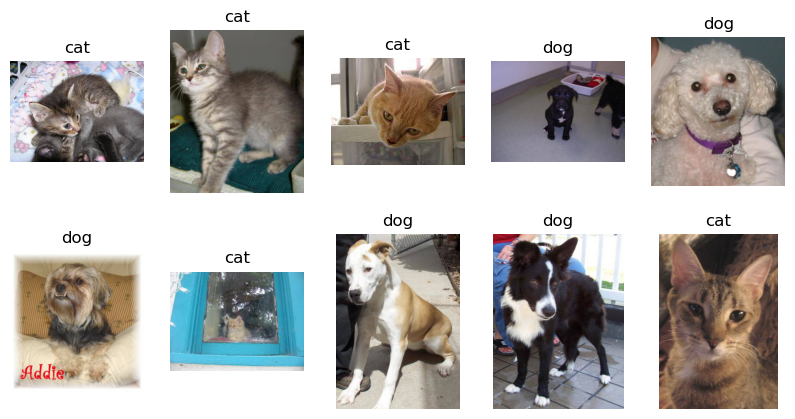

In [8]:

sample_labels=labels[10:20]
sample_images=load_batch_of_images(filenames[10:20])
fig, ax=plt.subplots(2,5,figsize=(10,5))
for i in range(10):
    ax[i//5,i%5].imshow(sample_images[i])
    ax[i//5,i%5].set_title(classes[sample_labels[i]])
    ax[i//5,i%5].axis('off')
plt.show()

#         i//5      i%5
# 0 -->    0         0
# 1 -->    0         1
# 2 -->    0         2
# 3 -->    0         3
# 4 -->    0         4
# 5 -->    1         0
# 6 -->    1         1
# 7 -->    1         2
# 8 -->    1         3
# 9 -->    1         4

In [10]:
def load_batch_as_tensors(filenames, labels, start_idx, batch_size):
    '''
    :param filenames: filenames of images
    :param labels: labels of images
    :param start_idx: start index of batch
    :param batch_size: batch size
    :return: batch of images as tensors with size 224x224, batch of labels as tensors
    '''
    batch_filenames=filenames[start_idx:start_idx+batch_size]
    batch_images=load_batch_of_images(batch_filenames)
    batch_labels=[labels[start_idx+i] for i in range(batch_size)]
    batch_tensors=[torchvision.transforms.ToTensor()(image)/255.0 for image in batch_images]
    # resize images to 224x224
    batch_tensors=[torchvision.transforms.Resize((224,224), antialias=True)(tensor) for tensor in batch_tensors]
    return torch.stack(batch_tensors), torch.tensor(batch_labels, dtype=torch.long)

xb, yb=load_batch_as_tensors(filenames, labels, 0,10)
print("xb shape", xb.shape)
print("yb shape", len(yb))
yb

xb shape torch.Size([10, 3, 224, 224])
yb shape 10


tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 1])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42, shuffle=True)

In [18]:
class DogsAndCatsModel(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.layer1=torch.nn.Sequential(
            # 3 input channels, 32 output channels, 5x5 kernel size
            # stride=2 --> means that kernel will move 2 pixels at a time
            # padding=2 --> means that we will add 2 pixels of padding on each side
            torch.nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),
            # out.shape --> (batch_size, 32, 112, 112)
            # Maxpool = der höchste Wert in einem 2x2 Fenster wird genommen
            # stride=2 --> means that kernel will move 2 pixels at a time
            # kernel_size=2 --> means that we will use a 2x2 kernel
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # out.shape --> (batch_size, 32, 56, 56)
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout(p)
        )  # out.shape --> (batch_size, 32, 56, 56)
        self.layer2=torch.nn.Sequential(
            torch.nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),
            # out.shape --> (batch_size, 128, 28, 28)
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # out.shape --> (batch_size, 128, 14, 14)
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(p)
        )
        self.layer3=torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            # out.shape --> (batch_size, 256, 7, 7)
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # out.shape --> (batch_size, 256, 3, 3)
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(p)
        )

        self.fc1=torch.nn.Sequential(
            torch.nn.Linear(256*3*3, 300),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(300)
        )
        self.fc2=torch.nn.Sequential(
            torch.nn.Linear(300, 2),
            torch.nn.Softmax(dim=1)
        )
        
    def forward(self, xb):
        out=self.layer1(xb)
        out=self.layer2(out)
        out=self.layer3(out)
        #print(out.shape)
        out=out.reshape(out.size(0), -1)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

model=DogsAndCatsModel()
model(xb).shape

torch.Size([10, 2])

In [19]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [20]:
def get_batch(x, y, batch_size):
    batch_count=len(x)//batch_size
    for i in range(batch_count-1):
        xb, yb=load_batch_as_tensors(x,y, i*batch_size+batch_size, batch_size)
        yield xb.to(device), yb.to(device)

model = DogsAndCatsModel().to(device)
xb, yb = next(get_batch(X_train, y_train, 64))
print(xb.shape)
model(xb).shape

torch.Size([64, 3, 224, 224])


torch.Size([64, 2])

In [24]:
def get_accuracy(x, y):
    correct=0
    for xb, yb in get_batch(x, y, batch_size):
        y_hat=model(xb)
        y_pred=torch.argmax(y_hat, dim=1)
        correct+=(y_pred==yb).sum().item()
    return correct/len(x)

In [25]:
# eigenes Modell wird erstellt
model = DogsAndCatsModel().to(device)
lr=0.01
batch_size=128

# loss function
# Mean Squared Error
# die Lossfunction von Pytorch müssen erstmal erstellt werden mit ()
loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.6)

def train_batch(xb, yb):
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def train_epoch(x, y):
    losses=[]
    for xb, yb in tqdm(get_batch(x, y, batch_size), total=len(x)//batch_size-1):
        losses.append(train_batch(xb, yb))
    return losses, get_accuracy(X_test, y_test)


In [26]:
all_losses=[]

  0%|          | 0/155 [00:00<?, ?it/s]

accuracy:  0.6794


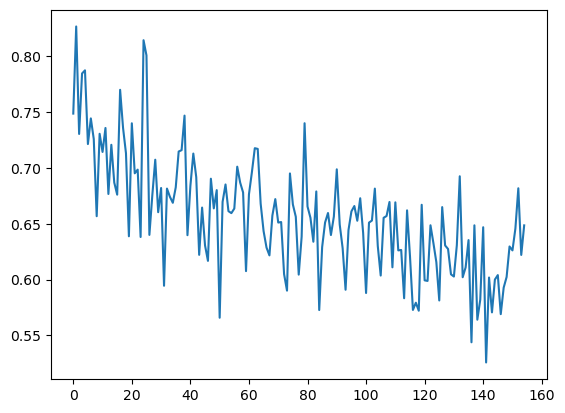

In [27]:
losses, acc=train_epoch(X_train, y_train)
all_losses.extend(losses)
print("accuracy: " , acc)
plt.plot(all_losses)

  0%|          | 0/155 [00:00<?, ?it/s]

accuracy:  0.7024


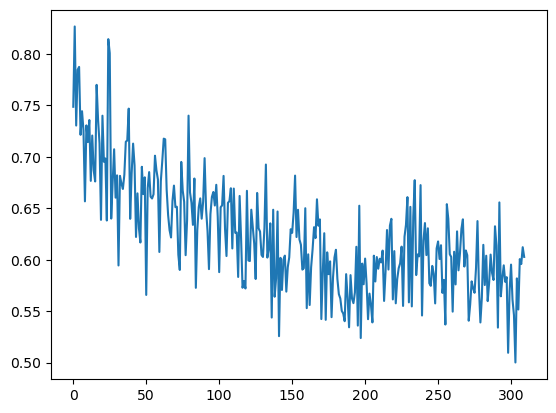

In [28]:
losses, acc=train_epoch(X_train, y_train)
all_losses.extend(losses)
print("accuracy: " , acc)
plt.plot(all_losses)

  0%|          | 0/155 [00:00<?, ?it/s]

accuracy:  0.7428


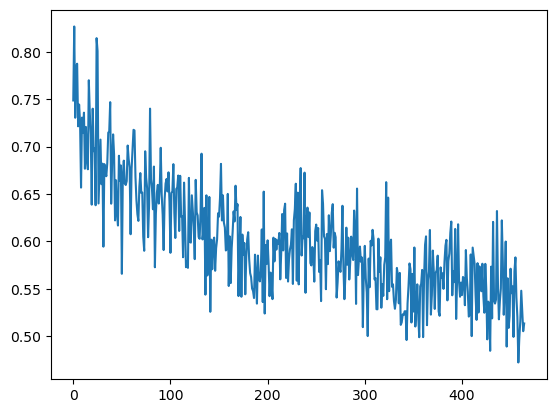

In [29]:
losses, acc=train_epoch(X_train, y_train)
all_losses.extend(losses)
print("accuracy: " , acc)
plt.plot(all_losses)

  0%|          | 0/155 [00:00<?, ?it/s]

accuracy:  0.747


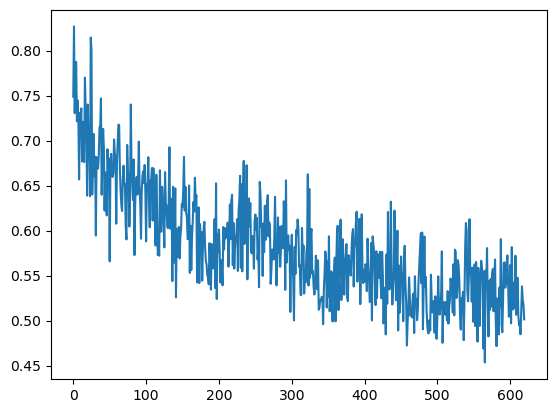

In [30]:
losses, acc=train_epoch(X_train, y_train)
all_losses.extend(losses)
print("accuracy: " , acc)
plt.plot(all_losses)

  0%|          | 0/155 [00:00<?, ?it/s]

accuracy:  0.7444


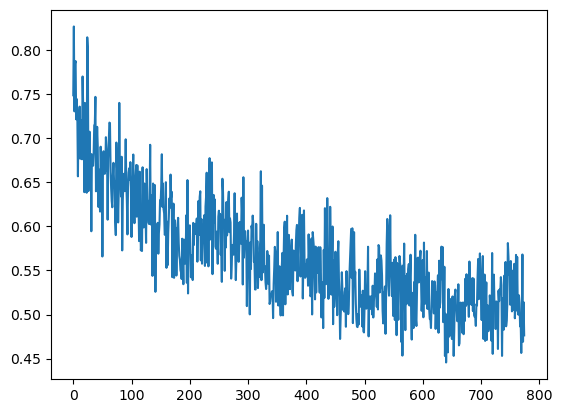

In [31]:
losses, acc=train_epoch(X_train, y_train)
all_losses.extend(losses)
print("accuracy: " , acc)
plt.plot(all_losses)